In [1]:
!pip install kafka-python

     |████████████████████████████████| 246 kB 3.5 MB/s eta 0:00:01


In [ ]:
# 기본적인 Producer를 만드는 것은 간단하다
from kafka import KafkaProducer

producer = KafkaProducer(bootstrap_servers = ['localhost:9092'])

producer.send('first-topic', b'hello first topic')
producer.flush()

In [ ]:
# 위와 같이 간단하게 기본적인 consumer를 만들 수 있다
from kafka import KafkaConsumer

consumer = KafkaConsumer('first-topic', bootstrap_servers = ['localhost:9092'])

for msgs in consumer:
    print(msgs)

실행하면 다음과 같이 Producer에서 전송한 메시지를 Consumer로 확인할 수 있다.
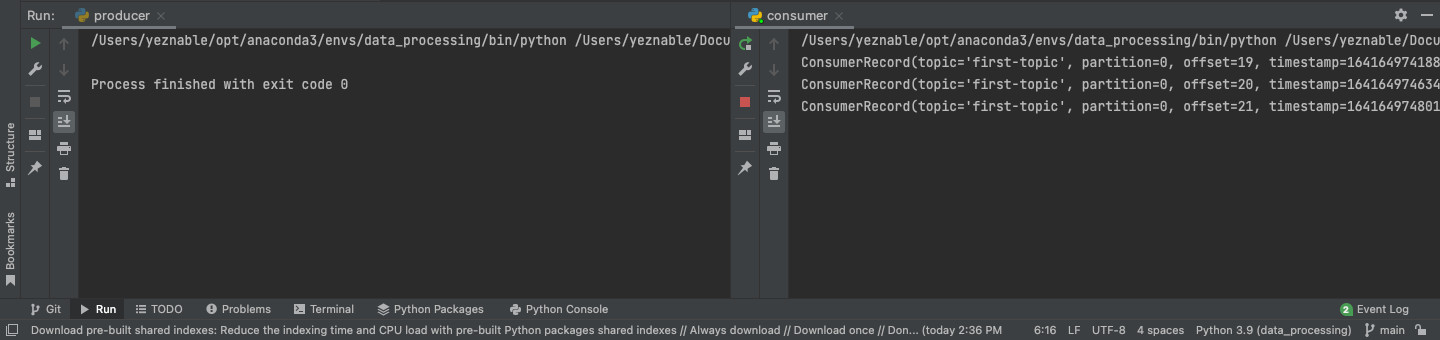

## Broker 분산 시뮬레이션 환경 구축
여러개의 Broker를 관리하는 방법을 익히기 위해 Docker를 활용한다.  
https://docs.docker.com/get-docker/ 링크로 들어가 맞는 버전의 도커를 설치한다.

In [ ]:
# docker를 생성하기 위해 docker-compose.yml을 다음과 같이 작성한다.
version: '3'
services:
  zookeeper:
    image: zookeeper:3.7
    hostname: zookeeper
    ports:
      - "2181:2181"
    environment:
      ZOO_MY_ID: 1
      ZOO_PORT: 2181
      ZOO_SERVERS: server.1=zookeeper:2888:3888
    volumes:
      - ./data/zookeeper/data:/data
      - ./data/zookeeper/datalog:/datalogco

In [ ]:
# 다음 명령어를 실행하면 docker에 zookeeper환경이 다운로드 받아진다.
!cd Documents/GitHub/Data_Processing/Kafka
!docker-compose up

위와 같은 과정을 통해 zookeeper 인스턴스를 실행시키니  
터미널에서는 다음과 같은 출력이 나타나고  
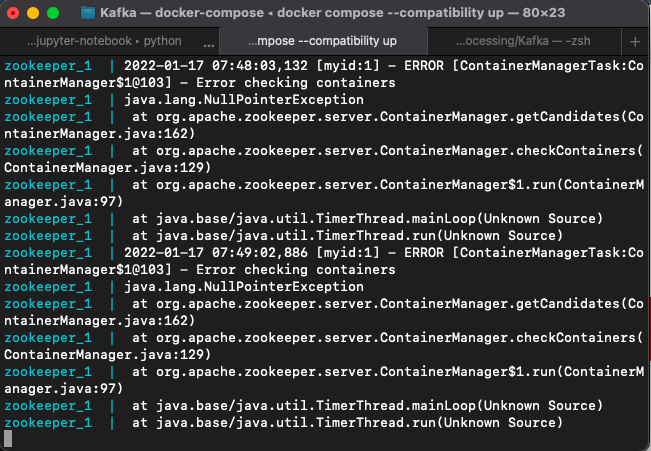
  
도커 화면에는 다음과 같은 인스턴스가 생성되며  
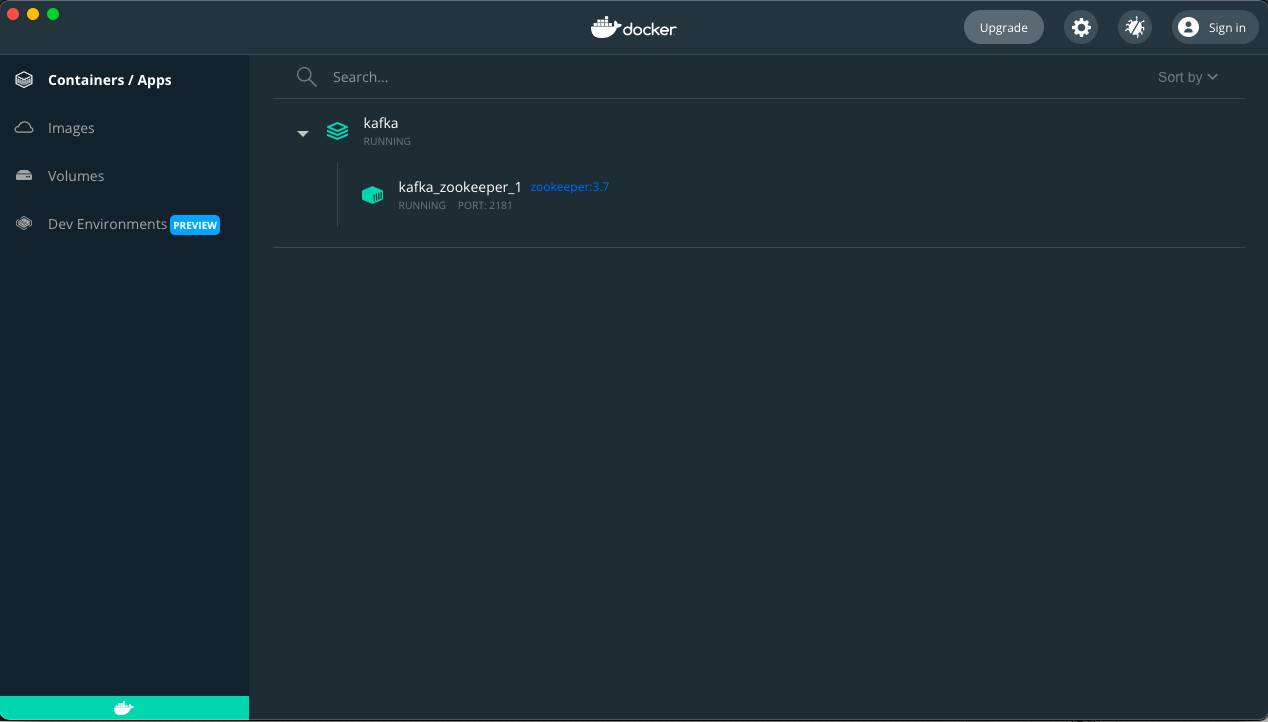  
  
netstat을 통해 2181 포트가 LISTEN 상태인 것을 확인할 수 있다.
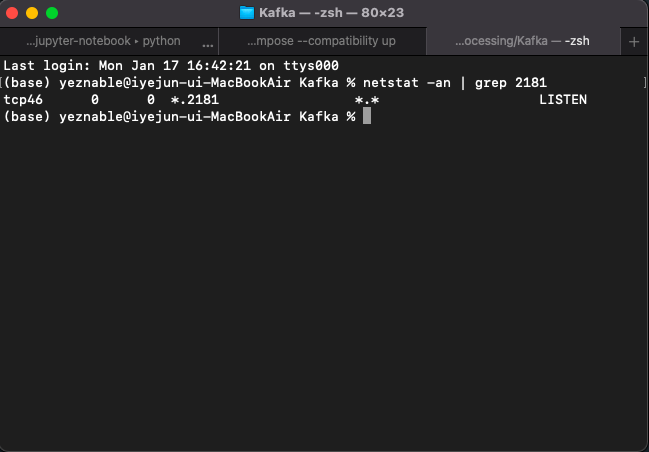

------------

이제 kafka broker를 3개 더 생성하고 kafdrop 또한 설정하여 사용하기 위해 docker-compose.yml파일을 다음과 같이 작성한다.

In [ ]:
version: '3'
services:
  zookeeper:
    image: zookeeper:3.7
    hostname: zookeeper
    ports:
      - "2181:2181"
    environment:
      ZOO_MY_ID: 1
      ZOO_PORT: 2181
    volumes:
      - ./data/zookeeper/data:/data
      - ./data/zookeeper/datalog:/datalog
  kafka1:
    image: confluentinc/cp-kafka:7.0.0
    hostname: kafka1
    ports:
      - "9091:9091"
    environment:
      KAFKA_ADVERTISED_LISTENERS: LISTENER_DOCKER_INTERNAL://kafka1:19091,LISTENER_DOCKER_EXTERNAL://${DOCKER_HOST_IP:-127.0.0.1}:9091
      KAFKA_LISTENER_SECURITY_PROTOCOL_MAP: LISTENER_DOCKER_INTERNAL:PLAINTEXT,LISTENER_DOCKER_EXTERNAL:PLAINTEXT
      KAFKA_INTER_BROKER_LISTENER_NAME: LISTENER_DOCKER_INTERNAL
      KAFKA_ZOOKEEPER_CONNECT: "zookeeper:2181"
      KAFKA_BROKER_ID: 1
      KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR: 1
    volumes:
      - ./data/kafka1/data:/tmp/kafka-logs
    depends_on:
      - zookeeper
  kafka2:
    image: confluentinc/cp-kafka:7.0.0
    hostname: kafka2
    ports:
      - "9092:9092"
    environment:
      KAFKA_ADVERTISED_LISTENERS: LISTENER_DOCKER_INTERNAL://kafka2:19092,LISTENER_DOCKER_EXTERNAL://${DOCKER_HOST_IP:-127.0.0.1}:9092
      KAFKA_LISTENER_SECURITY_PROTOCOL_MAP: LISTENER_DOCKER_INTERNAL:PLAINTEXT,LISTENER_DOCKER_EXTERNAL:PLAINTEXT
      KAFKA_INTER_BROKER_LISTENER_NAME: LISTENER_DOCKER_INTERNAL
      KAFKA_ZOOKEEPER_CONNECT: "zookeeper:2181"
      KAFKA_BROKER_ID: 2
      KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR: 1
    volumes:
      - ./data/kafka2/data:/tmp/kafka-logs
    depends_on:
      - zookeeper
  kafka3:
    image: confluentinc/cp-kafka:7.0.0
    hostname: kafka3
    ports:
      - "9093:9093"
    environment:
      KAFKA_ADVERTISED_LISTENERS: LISTENER_DOCKER_INTERNAL://kafka3:19093,LISTENER_DOCKER_EXTERNAL://${DOCKER_HOST_IP:-127.0.0.1}:9093
      KAFKA_LISTENER_SECURITY_PROTOCOL_MAP: LISTENER_DOCKER_INTERNAL:PLAINTEXT,LISTENER_DOCKER_EXTERNAL:PLAINTEXT
      KAFKA_INTER_BROKER_LISTENER_NAME: LISTENER_DOCKER_INTERNAL
      KAFKA_ZOOKEEPER_CONNECT: "zookeeper:2181"
      KAFKA_BROKER_ID: 3
      KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR: 1
    volumes:
      - ./data/kafka3/data:/tmp/kafka-logs
    depends_on:
      - zookeeper
  kafdrop:
    image: obsidiandynamics/kafdrop
    restart: "no"
    ports:
      - "9000:9000"
    environment:
      KAFKA_BROKER_CONNECT: "kafka1:19091"
    depends_on:
      - kafka1
      - kafka2
      - kafka3

In [ ]:
# docker-compose.yml을 수정하였으니 docker-compose up을 다시 실행하는데
# 이전 설정이 이후 실행에 영향을 줄 수 있으므로 아래 명령어로 설정을 클리어한 뒤 실행한다.
!docker-compose rm -svf
!docker-compose up

kafka 설정을 추가한 docker-compose.yml로 docker-compose up을 실행하고나면
첫 실행에는 다음과 같은 다운로드가 한동안 진행된다.
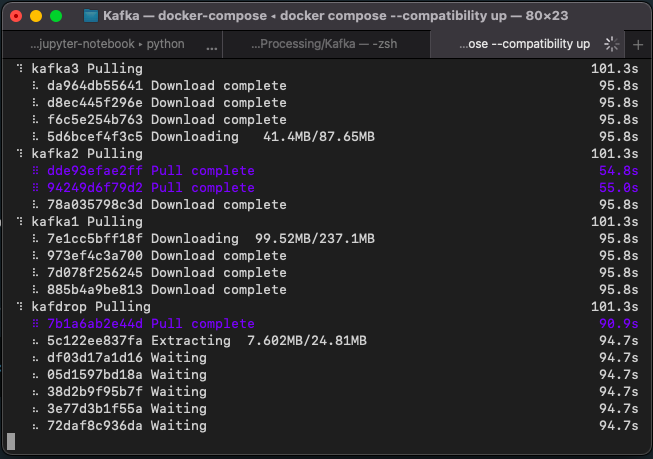

다운로드가 완료된 후에는 다음과 같이 터미널에서 docker가 작동하는 로그를 볼 수 있고  
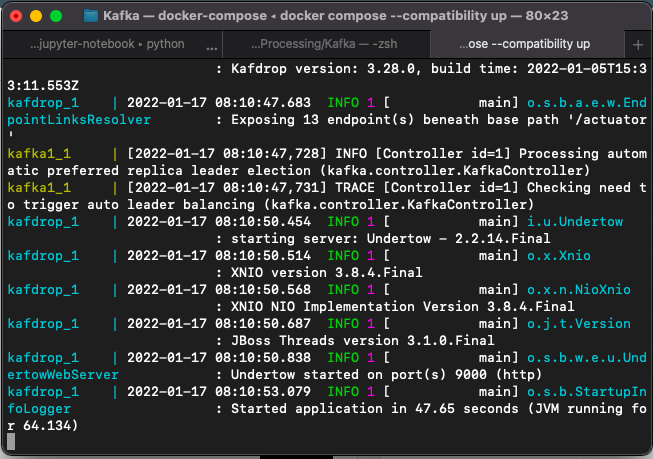
  
docker 대시보드를 확인하면 설정한 모든 인스턴스가 실행되고 있음을 확인할 수 있다.
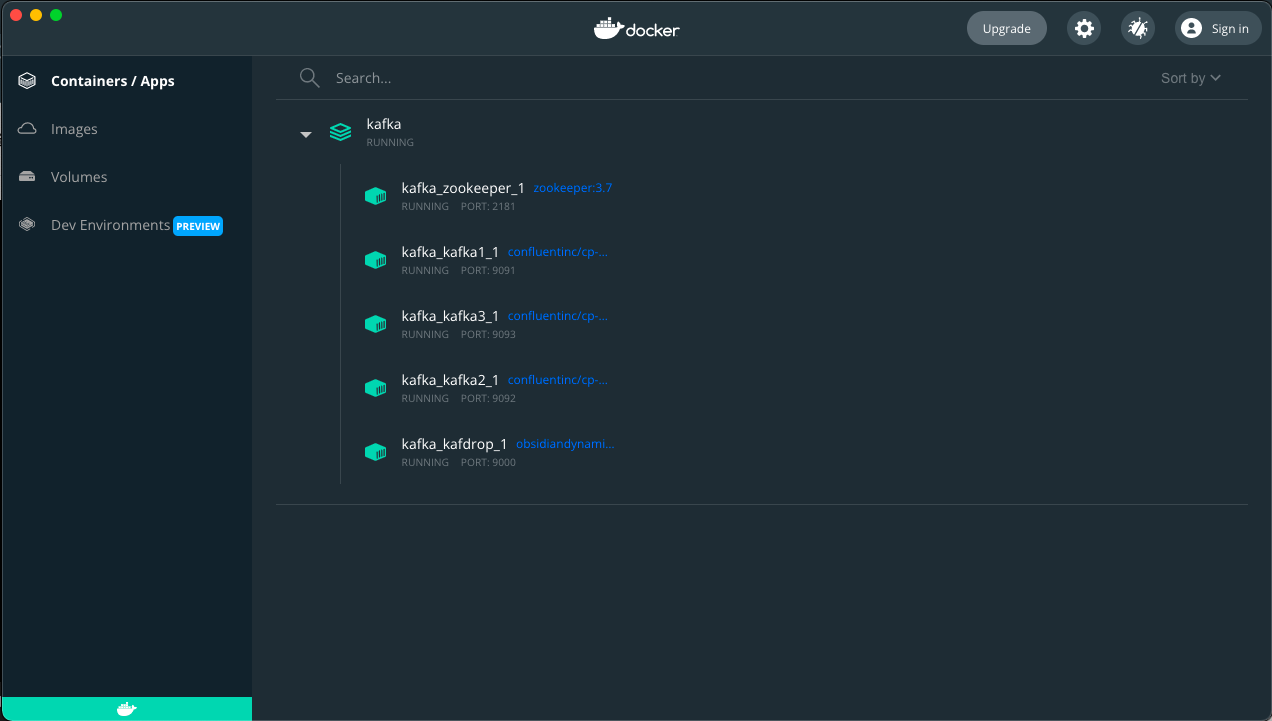
  
kafdrop의 주소로 설정한 localhost:9000에 접속해보면 다음과 같이 제대로 접속되는 것 또한 확인할 수 있다.
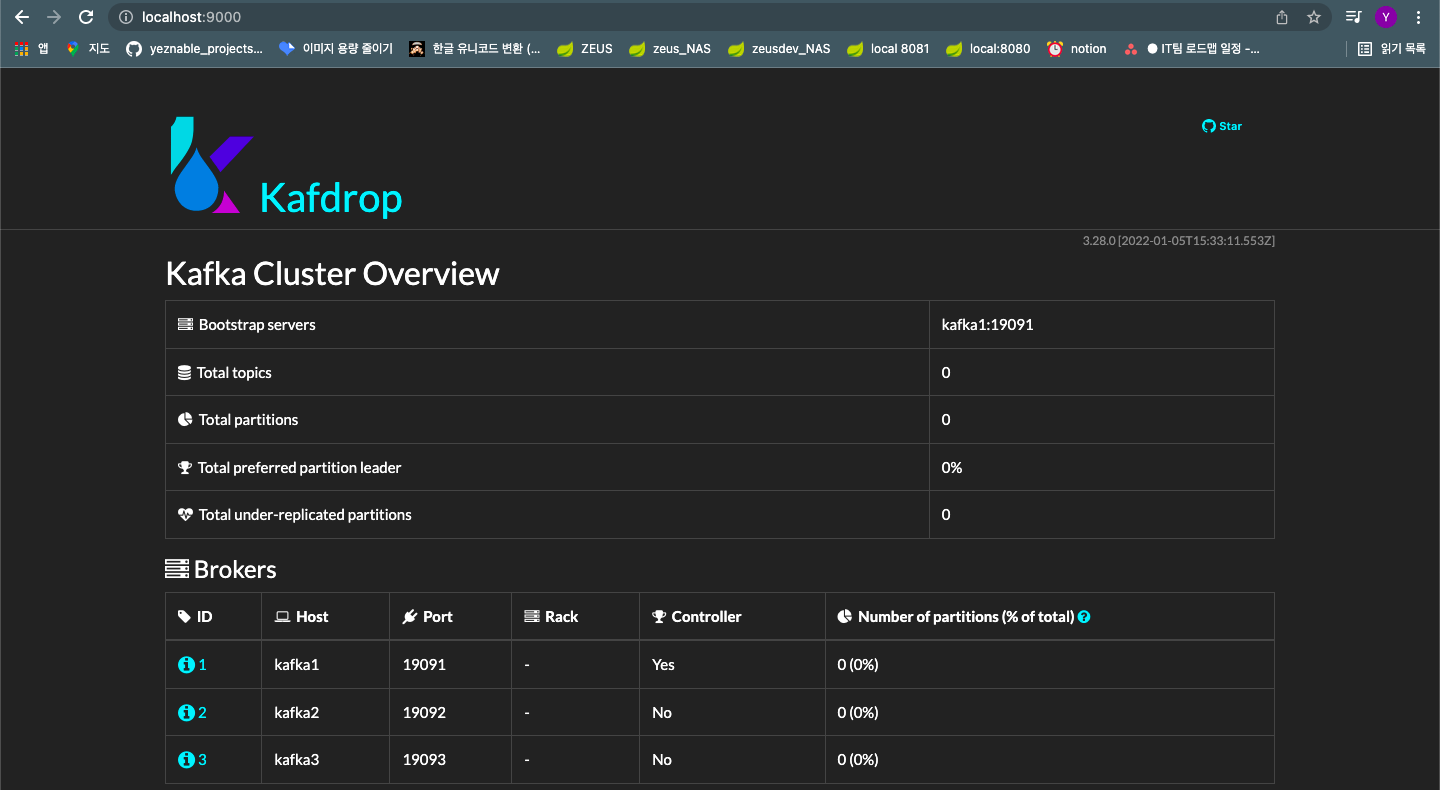

## Docker로 구현한 Broker 분산 시뮬레이션 환경 활용
  
위의 과정을 통해 docker에 zookeeper, 3개의 kafka(broker), kafdrop으로 구성된 환경을 마련하였다.
이제 해당 환경에 접근하여 활용한다.

In [ ]:
# docker 내의 환경에 접근하고 명령어를 접근하기 위한 형식은 docker exec -it {id} {명령어} 이다.
# kafka_kafka1_1에 다음과 같은 명령어로 topic을 생성할 수 있다.
docker exec -it kafka_kafka1_1 kafka-topics --bootstrap-server=localhost:19091 --create --topic first-cluster-topic --partitions 3 --replication-factor 1

실행 후 kafdrop에서 명령어대로 생성된 topic을 확인할 수 있다.
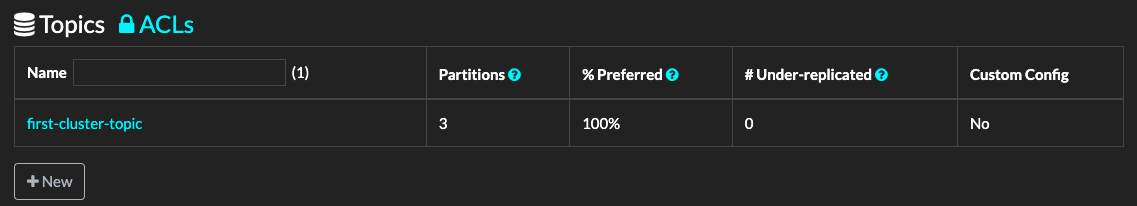
  
사실 그냥 kafdrop에서 UI를 통해서 topic을 관리할 수 있다 앞으로는 그렇게 활용하도록 하자